In [1]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

# Amino acid uptake in 143B GOT DKO cells
In this notebook I will process and plot data from an experiment were I quantified amino acid uptake from media over time to determine the total aspartate consumption flux.
Typically, cells do not uptake aspartate; however, with SLC1A3 expression they do.
But even with SLC1A3 expression and environmental aspartate available, aspartate is synthesized by cells making it hard to disentangle how much is taken up vs synthesized.
Even using labelled aspartate is not a perfect solution because a large pool of unlabelled aspartate is bound in protein and will exchange with the pool of free aspartate.
Additionally, aspartates nitrogen donating reactions will return the carbon skeleton that can be recycled be to aspartate.

To solve this, in addition to SLC1A3 expression, GOT1 and GOT2 was knockout of 143B cells and a monoclonal line was isolated.
In this cell line, every aspartate consumed in any reaction has to come from the media; therefore, the media depletion of aspartate is corresponding to the sum of all aspartate consumption fluxes.

The experiment was setup like the following:
* Seed 3x 6-well plates with 143B GOT DKO, 200,000 cells/well in 3 mL DMEM (dialyzed FBS) + 500 μM Asp.
* After 24 h, count the first plate, start the experiment by switching the two remaining plates to fresh media and take two media samples at t=0.
* After another 23 and 31 hours media samples (10 μL) was taken and put into 990 μL 80% MeOH.
* After the last media sample determine the media remaining in each well to take evaporation into account when doing quantitation.
* Then count the plate used for media sampling as well as the third plate. Note down cell volume as well as number.
* Use the count data to calculate the proliferation rate and then use the timestamp and final count from the media sampled plate to impute cell counts at t=0 and the two sampling times for each well.
* Calculate the "volume hours" (see below) as well as total volume for each well at each sampling time.
* Process the media samples by spinning out protein, transferring 400 μL to fresh tube, dry and reconstitute in 40 μL of 80 % MeOH with internal standards. This gives yields a 10 fold dilution.
* Quantify all amino acids using LCMS.




### How to calculate flux
For cell count ($y$), the cell counts over time is defined as an exponential function ($y(t)$) with proliferation rate $K$ and cell count at $t=0$ being $y_0$:
$$
y(t) = y_0 2^{K t}
$$

If we assume that amino acid uptake into a cell is constant, the uptake rate (also called influx) can be defined as the total molar uptake over at time range divided by the total area under the cell count curve over the same time range.

Formally, with $F_i$ being the influx and $n(t)$ being the molar quantity of a compound $i$, and $t_1$ and $t_2$ first and second timepoint, respectively, defining the time range:
$$
F_i = \frac{n_i(t_1) - n_i(t_2)}{\int_{t_1}^{t_2} y(t) dt}
$$

Using $\Delta$ to indicate we can simplify the above:
$$
F_i = \frac{\Delta n_i}{\int_{t_1}^{t_2} y(t) dt} = \frac{\Delta n_i}{\frac{y_0 2^{K t_2}}{K\ \text{ln}(2)} - \frac{y_0 2^{K t_1}}{K\ \text{ln}(2)}} = \frac{\Delta n_i}{\frac{y_0 (2^{K t_2} - 2^{K t_1})}{K\ \text{ln}(2)}}
$$
The denominator is equal to the area under the cell count curve over the same time range ($t_1$ to $t_2$), this is sometimes referred to as "cell hours" becuase of its unit is time, typically in hours.

Using cell hours it is possible to calculate the molar quantity taken up per cell per hour, typically as: $\frac{\text{fmol}}{\text{cell}\times h}$.
However, this makes it hard to compare accross cell lines because of variability in cell size. To fix this, simply redefine the problem from integrating the area under the cell count curve to the area under the volumne increase curve.
This is trivial using a volume per cell multiplier ($V_c$):
$$
V(t) = y(t) V_c = V_c y_0 2^{t K}
$$

Since $V_c$ is indenpendent of time, it is not integrated and we get:
$$
F_i = \frac{\Delta n_i}{\frac{V_c y_0 (2^{K t_2} - 2^{K t_1})}{K\ \text{ln}(2)}}
$$

Since $V_c$ is a volume, we have a denominator with typical unit of $\frac{L}{h}$.
We could call this "volume hours", and dividing the molar quantity onto this we get the typical unit of $\frac{\text{mM}}{h}$ which is comparable accross cell lines with different sizes.

Sometimes it can be usefull to convert the influx of a compound to the intracellular concentration of the compound.
In doing this we assume that the influxed compound is passively accumulating inside the cell and this can be a reasonable assumption when looking at for instance essential amino acids.
For example take leucine, by adding the amount of free leucine with that bound in protein it should correspond to that being taken up through influx as it is neither synthesized nor broken down.
To convert flux to cell concentration for compound $i$ observe the following rearrangement of above:
$$
F_i = K\ \text{ln}(2) \frac{\Delta n_i}{V_c y_0 (2^{K t_2} - 2^{K t_1})}
$$

The fraction is the molar quantity of consumed compound $i$ divided by the accumulation of cell volume i.e. the intracellular concentration of compound $i$ ($C_i$).
Thus we have:
$$
F_i = K\ \text{ln}(2) C_i => C_i = \frac{F_i}{K\ \text{ln}(2)}
$$



In [2]:
AAcode = {
    'Alanine': 'Ala',
    'Arginine': 'Arg',
    'Asparagine': 'Asn',
    'Aspartate': 'Asp',
    'Glutamate': 'Glu',
    'Glutamine': 'Gln',
    'Glycine': 'Gly',
    'Isoleucine': 'Ile',
    'Leucine': 'Leu',
    'Lysine': 'Lys',
    'Methionine': 'Met',
    'Phenylalanine': 'Phe',
    'Proline': 'Pro',
    'Serine': 'Ser',
    'Threonine': 'Thr',
    'Tryptophan': 'Trp',
    'Tyrosine': 'Tyr',
    'Valine': 'Val'
}

AA_protMW = {
'Aspartate': 115.08742,
'Asparagine': 114.10262,
'Arginine': 156.18572,
'Glycine': 57.05132,
'Glutamate': 129.11402,
'Tyrosine': 163.17322,
'Histidine': 137.13932,
'Glutamine': 128.12922,
'Serine': 87.07732,
'Proline': 97.11522,
'Threonine': 101.10392,
'Tryptophan': 186.20992,
'Lysine': 128.17232,
'Methionine': 131.19602,
'Leucine': 113.15762,
'Cysteine': 103.14292,
'Valine': 99.13102,
'Phenylalanine': 147.17382,
'Isoleucine': 113.15762,
'Alanine': 71.07792
}

In [3]:
def impute_conc(piece_wise_fit_metab, response_ratio):
    '''
    This function imputes the concentration from a response ratio.
    '''
    response_ratio_range = np.array(list(piece_wise_fit_metab.keys()))
    mask_range = [response_ratio >= min_v and response_ratio <= max_v for max_v, min_v in response_ratio_range]
    k = tuple(response_ratio_range[mask_range][0])
    conc = piece_wise_fit_metab[k](response_ratio)
    estimator = 'intrapolation'
    if 0 in k:
        estimator = 'extrapolation under'
    elif np.inf in k:
        estimator = 'extrapolation over'
    return(conc, estimator)

### Calculate quantities and fluxes

In [4]:
### Read quantification function ###
# dict_pickle_fnam = 'input/AA-quant_oct_20.pickle'
dict_pickle_fnam = 'input/AA-quant_oct_20_M1.pickle'
with open(dict_pickle_fnam, 'rb') as handle:
    piece_wise_fit_AA = pickle.load(handle)
# Merge the two quantitation dictionaries:
piece_wise_fit_quant = {**piece_wise_fit_AA}

### Read measurements ###
### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('input/Asp-uptake-flux.xlsx', sheet_name=None)
annotation_df = pd.read_excel('input/annotations.xlsx')
metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k])
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Area'] / metab_dict_mes[k]['ISTD Response']
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio'].fillna(0).replace(np.inf, 0)
        # CAA was reconstituted in 400 uL instead of 500 uL
        # CAA peak will then be 5/4 times what it should be
        ## RR will then be 4/5 of what it should be
        # Correction factor: 5/4
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio'] * 5/4
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Flag Details', 'Filename', 'Type', 'RT'], axis=1)

### Impute concentration and add to metabolite dataframe ###
rr_mes = dict() # for plotting 
imp_conc_mes = dict() # for plotting
for metab in metab_names_mes[:]:
    # Assign imputed concentration:
    if metab in piece_wise_fit_quant:
        conc_list = list()
        estimator_list = list()
        for rr in metab_dict_mes[metab]['Response Ratio'].values:
            conc, estimator = impute_conc(piece_wise_fit_quant[metab], rr)
            conc_list.append(conc)
            estimator_list.append(estimator)
        metab_dict_mes[metab]['imputed_sample_conc'] = conc_list
        metab_dict_mes[metab]['imputed_sample_estimator'] = estimator_list

        # Extract data for plotting:
        if metab in rr_mes:
            rr_mes[metab].extend(list(metab_dict_mes[metab]['Response Ratio'].values))
            imp_conc_mes[metab].extend(list(metab_dict_mes[metab]['imputed_sample_conc'].values))
        else:
            rr_mes[metab] = list(metab_dict_mes[metab]['Response Ratio'].values)
            imp_conc_mes[metab] = list(metab_dict_mes[metab]['imputed_sample_conc'].values)

In [5]:
# Convert to media concentration and flux:
for metab in metab_names_mes:
    if metab in piece_wise_fit_quant:
        metab_dict_mes[metab]['undil_sample_conc'] = metab_dict_mes[metab]['imputed_sample_conc'] / metab_dict_mes[metab]['dilution_factor']
        metab_dict_mes[metab]['pmol'] = metab_dict_mes[metab]['undil_sample_conc'] * metab_dict_mes[metab]['Media_vol']
        blank_pmol = metab_dict_mes[metab][metab_dict_mes[metab]['Time'] == 0]['undil_sample_conc'].mean() * metab_dict_mes[metab]['Media_vol_t0']
        metab_dict_mes[metab]['nmol_depleted'] = (blank_pmol - metab_dict_mes[metab]['pmol']) * 1e-3
        # Influx in mM/h:
        metab_dict_mes[metab]['Influx'] = metab_dict_mes[metab]['nmol_depleted'] / metab_dict_mes[metab]['vol_hour'] * 1e-6
        # Total accumulated concentration:
        metab_dict_mes[metab]['Total conc.'] = metab_dict_mes[metab]['nmol_depleted'] / metab_dict_mes[metab]['vol_accum'] *1e-6

### Extract all metabolites for quantification - imputed conc. ###
df_imp = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'Area', 'ISTD Response', 'imputed_sample_conc', 'imputed_sample_estimator', 'undil_sample_conc', 'pmol', 'nmol_depleted', 'Influx', 'Total conc.'], axis=1)
for metab in metab_names_mes:
    if metab in piece_wise_fit_quant:
        assert(metab_dict_mes[metab]['Sample_name'].equals(df_imp['Sample_name']))
        df_imp[metab] = metab_dict_mes[metab]['imputed_sample_conc']
# Save data in Excel file (mM):
df_imp.to_excel('output/imputed-conc.xlsx', index=False)

### Extract all metabolites for quantification - flux ###
df_flux = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'Area', 'ISTD Response', 'imputed_sample_conc', 'imputed_sample_estimator', 'undil_sample_conc', 'pmol', 'nmol_depleted', 'Influx', 'dilution_factor', 'vol_hour', 'Media_vol', 'vol_accum', 'Total conc.', 'Media_vol_t0', 'Prlfr'], axis=1)
for metab in metab_names_mes:
    if metab in piece_wise_fit_quant:
        assert(metab_dict_mes[metab]['Sample_name'].equals(df_flux['Sample_name']))
        df_flux[metab] = metab_dict_mes[metab]['Influx']
# Save data in Excel file (mM/h):
df_flux.to_excel('output/influx.xlsx', index=False)

### Extract all metabolites for quantification - accumulated cell conc. ###
df_acc = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'Area', 'ISTD Response', 'imputed_sample_conc', 'imputed_sample_estimator', 'undil_sample_conc', 'pmol', 'nmol_depleted', 'Influx', 'dilution_factor', 'vol_hour', 'Media_vol', 'vol_accum', 'Total conc.', 'Media_vol_t0', 'Prlfr'], axis=1)
for metab in metab_names_mes:
    if metab in piece_wise_fit_quant:
        assert(metab_dict_mes[metab]['Sample_name'].equals(df_acc['Sample_name']))
        df_acc[metab] = metab_dict_mes[metab]['Total conc.']
# Save data in Excel file (mM):
df_acc.to_excel('output/total-cell-conc.xlsx', index=False)

In [6]:
df_flux

,Sample_name,Time,Alanine pos,Arginine pos,Asparagine pos,Aspartate neg,Glutamate neg,Glutamine pos,Glycine neg,Isoleucine pos,Leucine pos,Lysine pos,Methionine pos,Phenylalanine pos,Proline pos,Serine neg,Threonine neg,Tryptophan pos,Tyrosine pos,Valine pos
0,AF1,0,-inf,-inf,inf,-inf,inf,-inf,inf,-inf,-inf,inf,-inf,-inf,inf,inf,-inf,-inf,-inf,-inf
1,AF2,0,inf,inf,-inf,inf,-inf,inf,-inf,inf,inf,-inf,inf,inf,-inf,-inf,inf,inf,inf,inf
2,AF3,23,-0.460100,3.946522,-2.323420,10.652977,-17.203029,72.378637,1.309988,8.004328,8.307042,4.412500,1.451859,2.865582,-0.634318,8.684345,4.717824,0.711582,2.730706,6.407100
3,AF4,23,-0.587258,3.599832,-3.130846,11.182461,-19.187684,72.656332,-0.180112,7.901155,8.426510,4.615662,1.387740,2.533191,-0.700051,8.953907,4.384644,0.624453,1.780162,5.733288
4,AF5,23,-0.553216,4.639968,-2.521337,11.335082,-18.386119,79.018754,1.400871,5.499583,12.651701,5.531987,1.759425,3.173547,-0.671364,8.947200,6.255253,0.725734,2.626386,6.542249
5,AF6,23,-0.631866,4.451200,-2.502185,11.472694,-18.045579,77.571934,0.638738,7.893675,7.799710,5.951363,1.582113,2.803601,-0.671199,9.097448,4.996721,0.683099,2.776012,5.685493
6,AF7,23,-0.525105,4.594340,-2.446893,11.962479,-17.347108,76.749527,1.425957,6.480909,12.526052,6.226135,1.711115,3.305652,-0.623528,9.852976,5.237600,0.870079,2.969953,6.873671
7,AF8,23,-0.656246,3.878106,-2.850961,11.705705,-20.507812,79.992701,0.365316,4.511881,12.574911,4.923024,1.439287,2.753396,-0.743389,9.207664,4.784204,0.645304,2.510906,5.396141
8,AF9,31,-0.688601,3.383184,-2.666236,10.443568,-13.069942,59.896871,0.720688,4.979777,8.817438,4.699850,1.339404,2.353769,-0.549235,9.017818,3.328289,0.621852,2.232774,4.369377
9,AF10,31,-0.706164,4.198046,-2.837270,11.996663,-13.939930,70.563264,1.107353,6.730389,10.616672,5.995028,1.743769,3.286012,-0.554816,9.483048,5.417586,0.799168,3.022165,6.767242


### Plot data - influx

In [7]:
# Rename to three letter amino acid code,
# Sort according to highest influx at 23 h
df_flux.columns = [v.split()[0] for v in df_flux.columns.values]
df_flux = df_flux.rename(columns=AAcode)
# Sort:
df_mean = df_flux.groupby(['Time']).mean(numeric_only=True).reset_index()
col_sele = df_mean.columns.values[1:]
sort_mask = df_mean.loc[1, col_sele].sort_values(ascending=False).index.values
sort_mask = np.concatenate([['Time'], sort_mask])
df_sort = df_flux.loc[:, sort_mask].copy()
# Remove t=0:
time_mask = df_sort['Time'] > 0
df_sort = df_sort[time_mask].copy()
# Flatten for plotting:
df_melt = df_sort.melt(id_vars=['Time'], var_name='Amino acid', value_name='Flux')

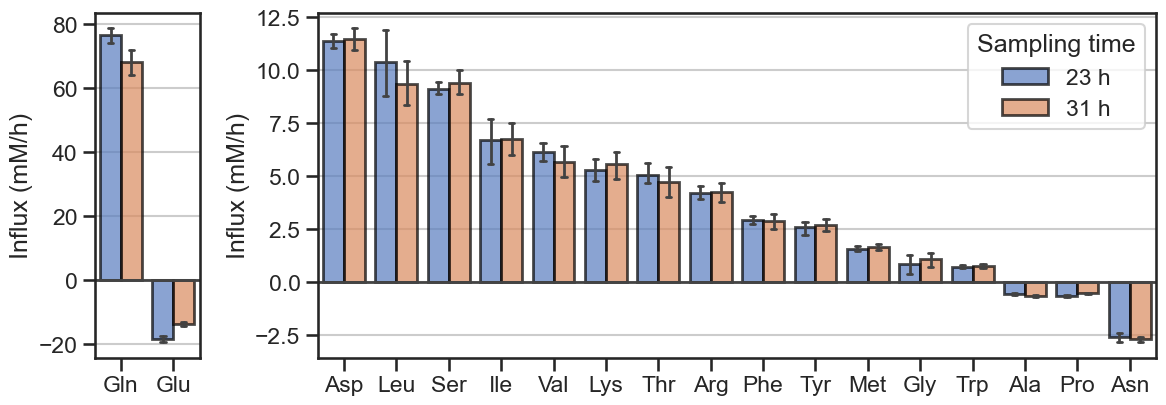

In [8]:
### Plot the influx ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.4), gridspec_kw={'width_ratios': [1, 8]})

# Small plot for Gln/Glu:
mask = df_melt['Amino acid'].isin(['Gln', 'Glu'])
g1 = sns.barplot(ax=ax1, x="Amino acid", y="Flux", hue="Time", data=df_melt[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax1.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Influx (mM/h)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)

# Plot the all other AAs:
g2 = sns.barplot(ax=ax2, x="Amino acid", y="Flux", hue="Time", data=df_melt[~mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax2.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g2.grid(True, axis='y')
g2.set_ylabel('Influx (mM/h)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=0);
#g2.set_ylim([-1.4, 5.6])
#g2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Add legend:
old_legend = g2.legend_
handles = old_legend.legend_handles
labels = ['23 h', '31 h']
title = 'Sampling time'
g2.legend(handles, labels, title=title);

# Show/save:
fig.tight_layout()
fig.savefig('output/influx.pdf')

In [10]:
# Save data in Excel file:
df_melt.to_excel('output/influx_flat.xlsx', index=False)

### Plot data - total cell concentration

In [9]:
# Rename to three letter amino acid code,
# Sort according to highest conc. at 23 h
df_acc.columns = [v.split()[0] for v in df_acc.columns.values]
df_acc = df_acc.rename(columns=AAcode)
# Sort:
df_mean = df_acc.groupby(['Time']).mean(numeric_only=True).reset_index()
col_sele = df_mean.columns.values[1:]
sort_mask = df_mean.loc[1, col_sele].sort_values(ascending=False).index.values
sort_mask = np.concatenate([['Time'], sort_mask])
df_sort = df_acc.loc[:, sort_mask]
# Remove t=0:
time_mask = df_sort['Time'] > 0
df_sort = df_sort[time_mask]
# Flatten for plotting:
df_melt = df_sort.melt(id_vars=['Time'], var_name='Amino acid', value_name='ACC')

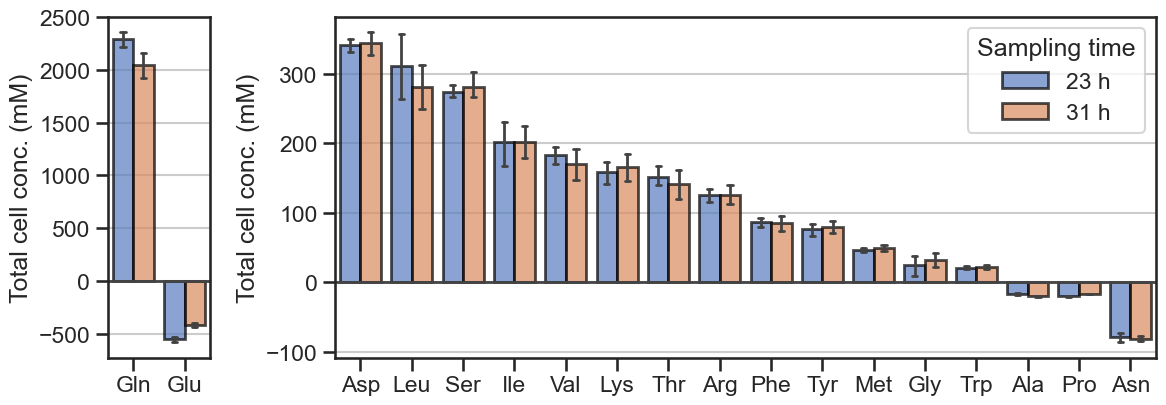

In [10]:
### Plot the influx ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.4), gridspec_kw={'width_ratios': [1, 8]})

# Small plot for Gln/Glu:
mask = df_melt['Amino acid'].isin(['Gln', 'Glu'])
g1 = sns.barplot(ax=ax1, x="Amino acid", y="ACC", hue="Time", data=df_melt[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax1.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)

# Plot the all other AAs:
g2 = sns.barplot(ax=ax2, x="Amino acid", y="ACC", hue="Time", data=df_melt[~mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax2.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g2.grid(True, axis='y')
g2.set_ylabel('Total cell conc. (mM)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=0);
#g2.set_ylim([-1.4, 5.6])
#g2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Add legend:
old_legend = g2.legend_
handles = old_legend.legend_handles
labels = ['23 h', '31 h']
title = 'Sampling time'
g2.legend(handles, labels, title=title);

# Show/save:
fig.tight_layout()
fig.savefig('output/total-cell-conc.pdf')